Cell 1: Environment Setup & Imports
At the very top, set up the connection between your notebook and your custom script.

In [1]:
import sys
import os
import struct
import numpy as np
import matplotlib.pyplot as plt

# Connect to your neural_network.py script
sys.path.append(os.path.abspath(''))
from neural_network import Network 

# Enable auto-reload so changes to your .py file are updated here
%load_ext autoreload
%autoreload 2

Cell 2: Data Loader Functions
Add the functions needed to read the .ubyte binary files shown in your dataset folder.

In [2]:
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num, rows * cols)
        return images / 255.0  # Normalize pixels

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

Cell 3: Loading Your Local Dataset
Use the specific path you provided to load the training and test sets.

In [3]:
import os
import numpy as np

# Use the base path from your successful download
download_path = "/home/codespace/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1"

# We go one level deeper: Folder Name / File Name
train_img_path = os.path.join(download_path, "train-images-idx3-ubyte", "train-images-idx3-ubyte")
train_lbl_path = os.path.join(download_path, "train-labels-idx1-ubyte", "train-labels-idx1-ubyte")
test_img_path  = os.path.join(download_path, "t10k-images-idx3-ubyte", "t10k-images-idx3-ubyte")
test_lbl_path  = os.path.join(download_path, "t10k-labels-idx1-ubyte", "t10k-labels-idx1-ubyte")

# Load the binary data
X_train = load_mnist_images(train_img_path)
y_train_raw = load_mnist_labels(train_lbl_path)
X_test = load_mnist_images(test_img_path)
y_test_raw = load_mnist_labels(test_lbl_path)

# One-hot encode the training labels (0-9)
y_train = np.zeros((y_train_raw.size, 10))
y_train[np.arange(y_train_raw.size), y_train_raw] = 1

print(f"✅ Success! X_train shape: {X_train.shape}")

✅ Success! X_train shape: (60000, 784)


Cell 4: Model Initialization & TrainingInitialize your Network with 784 input neurons to match the $28 \times 28$ pixel images.

In [4]:
# 1. Initialize
model = Network()
model.path([784, 256, 10]) 

# 2. Train with the exact parameters that gave 97.33% accuracy
print("Starting final training run...")
model.fit(
    X_train, y_train, 
    epoch=40, 
    learning_rate=0.001, 
    batch_size=64, 
    optimizer="ADAM", 
    loss_type="Cross_entropy", 
    regularization=(0.001, 0)
)

# 3. Save the weights
import os
folder = "final_97_model"
if not os.path.exists(folder): 
    os.makedirs(folder)

for i, layer in enumerate(model.layers):
    if hasattr(layer, 'weights_'):
        np.save(f"{folder}/L{i}_W.npy", layer.weights_)
        np.save(f"{folder}/L{i}_B.npy", layer.bias_)

print("✅ 97% Accuracy model saved successfully!")

Starting final training run...


Learning rate decayed to: 0.000800
Learning rate decayed to: 0.000640
Learning rate decayed to: 0.000512
Learning rate decayed to: 0.000410
Learning rate decayed to: 0.000328
Learning rate decayed to: 0.000262
Learning rate decayed to: 0.000210
✅ 97% Accuracy model saved successfully!


Cell 5: Testing & Accuracy Report
Finally, evaluate how well your model performs on the test data.

Final Test Accuracy: 97.33%


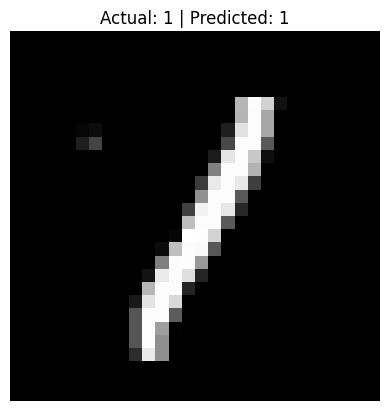

Final Training Accuracy: 99.16%


In [5]:
# 1. Predict on the test set
test_output = model.predict(X_test)
predicted_labels = np.argmax(test_output, axis=1)

# 2. Calculate accuracy percentage
accuracy = np.mean(predicted_labels == y_test_raw) * 100
print(f"Final Test Accuracy: {accuracy:.2f}%")

# 3. Visualize a random test prediction
idx = np.random.randint(0, len(X_test))
plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
plt.title(f"Actual: {y_test_raw[idx]} | Predicted: {predicted_labels[idx]}")
plt.axis('off')
plt.show()

# 4. Check Final Training Accuracy (Optional)
# We use 'model' instead of 'self' here
train_predictions = np.argmax(model.predict(X_train), axis=1)
train_targets = np.argmax(y_train, axis=1)
train_accuracy = np.mean(train_predictions == train_targets) * 100
print(f"Final Training Accuracy: {train_accuracy:.2f}%")

In [6]:
# Predict on the unseen 10,000 test images
test_output = model.predict(X_test)
test_predictions = np.argmax(test_output, axis=1)

# Compare with actual labels
final_acc = np.mean(test_predictions == y_test_raw) * 100
print(f"Final MNIST Test Accuracy: {final_acc:.2f}%")

Final MNIST Test Accuracy: 97.33%


The Multi-Digit Visualization

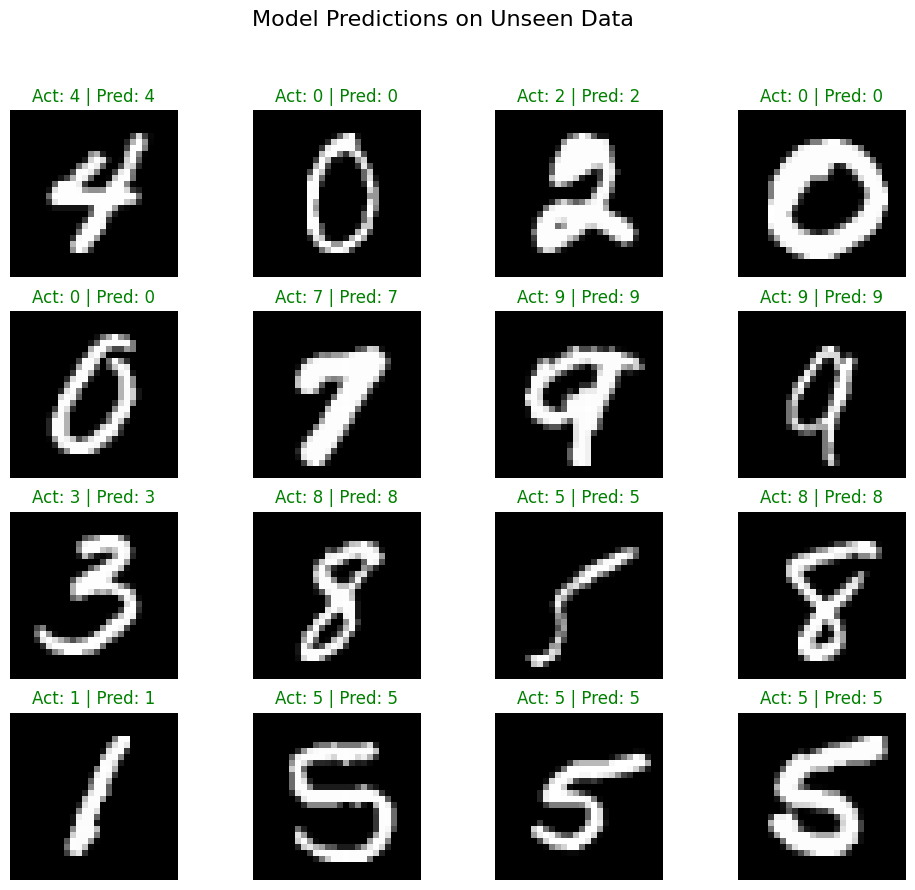

In [7]:
# 1. VISUALIZE MULTIPLE PREDICTIONS
plt.figure(figsize=(12, 10))
for i in range(16): # Show 16 digits
    idx = np.random.randint(0, len(X_test))
    img = X_test[idx].reshape(28, 28)
    
    # Get model prediction
    probs = model.predict(X_test[idx:idx+1])
    pred = np.argmax(probs)
    actual = y_test_raw[idx]
    
    plt.subplot(4, 4, i+1)
    plt.imshow(img, cmap='gray')
    # Green title if correct, Red if wrong
    color = 'green' if pred == actual else 'red'
    plt.title(f"Act: {actual} | Pred: {pred}", color=color)
    plt.axis('off')
plt.suptitle("Model Predictions on Unseen Data", fontsize=16)
plt.show()

Confusion Matrix

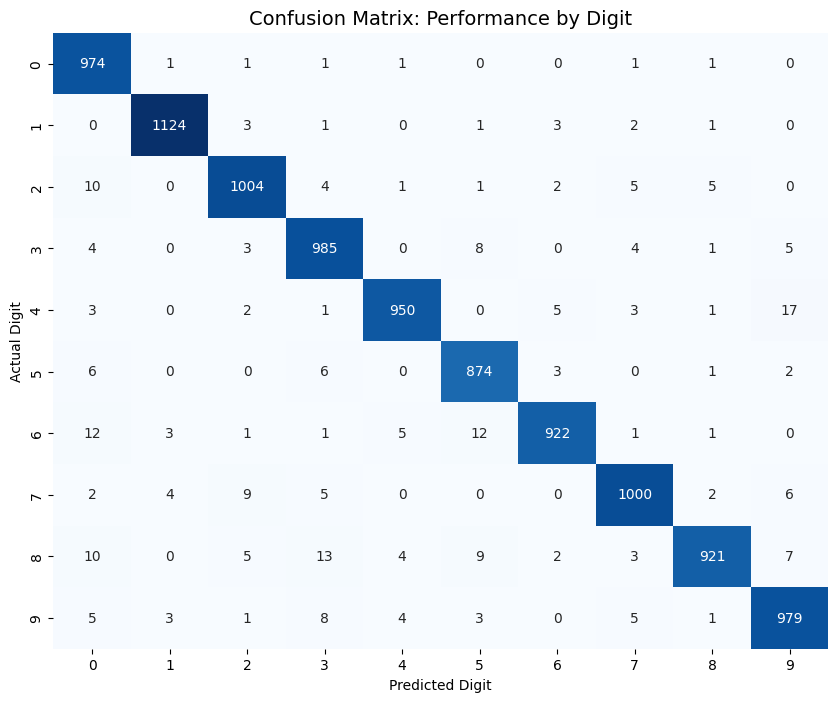

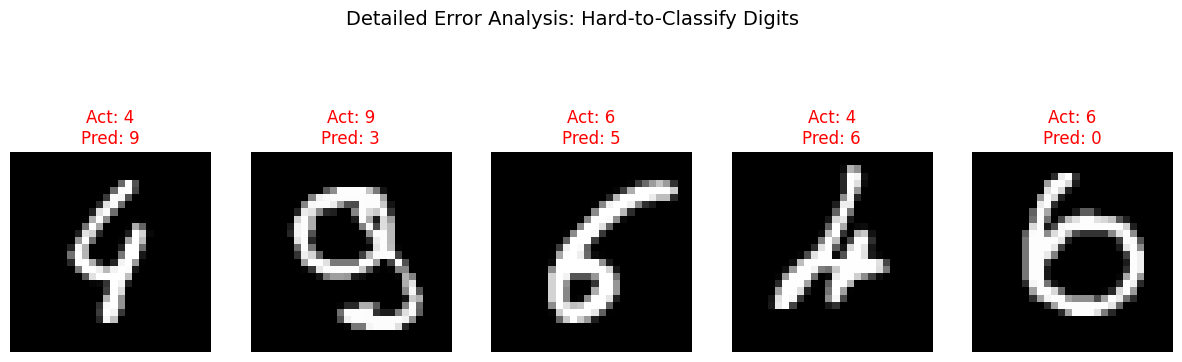

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. Generate Global Test Predictions
test_probs = model.predict(X_test)
test_preds = np.argmax(test_probs, axis=1)

# 2. Confusion Matrix Heatmap
cm = confusion_matrix(y_test_raw, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Performance by Digit', fontsize=14)
plt.xlabel('Predicted Digit')
plt.ylabel('Actual Digit')
plt.show()

# 3. Detailed Failure Analysis (Why did we miss?)
wrong_indices = np.where(test_preds != y_test_raw)[0]
plt.figure(figsize=(15, 5))
for i in range(min(5, len(wrong_indices))):
    idx = wrong_indices[i]
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Act: {y_test_raw[idx]}\nPred: {test_preds[idx]}", color='red')
    plt.axis('off')
plt.suptitle("Detailed Error Analysis: Hard-to-Classify Digits", fontsize=14)
plt.show()
